<a href="https://colab.research.google.com/github/humayun-mhk/Deep-Learning-Projects/blob/main/Cat_vs_Dog_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600  ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:07<00:00, 103MB/s]
100% 1.06G/1.06G [00:07<00:00, 153MB/s]


In [ ]:

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
#Matplot Images
import matplotlib.image as mpimg
# Tensflor and Keras Layer and Model and Optimize and Loss
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
# import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
#PreTrained Model VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
#Image Generator DataAugmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
# Warnings Remove
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import zipfile

path = "/content/dogs-vs-cats.zip"
New_path = "/content/All_data"
with zipfile.ZipFile(path, "r") as fil_rep:
  fil_rep.extractall(New_path)

In [ ]:
directory = "/content/All_data"

categories = ["cats", "dogs"]

file_names=[]
categories_labels = []

for category in categories:
    category_folder = os.path.join(directory,"train", category)
    category_filenames = os.listdir(category_folder)
    file_names.extend(category_filenames)
    categories_labels.extend([category] * len(category_filenames))

df = pd.DataFrame({
    "filename": file_names,
    "category" : categories_labels
})
df.shape

(20000, 2)

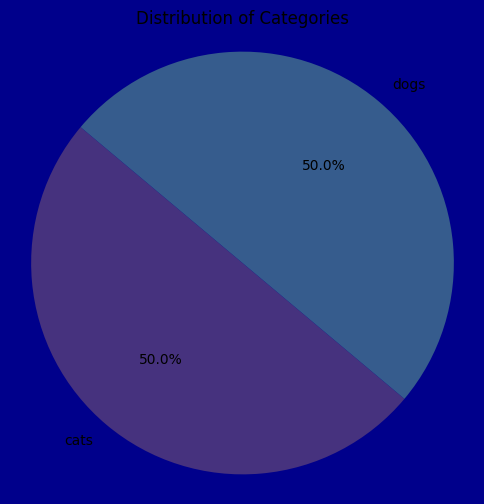

(20000, 2)

In [ ]:
# Count the occurrences of each category in the 'category' column
count = df['category'].value_counts()

# Create a pie chart using Seaborn
plt.figure(figsize=(6, 6) , facecolor='darkblue')
palette = sns.color_palette("viridis")
sns.set_palette(palette)
plt.pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories')
plt.axis('equal')

plt.show()  # Show the plot
df.shape

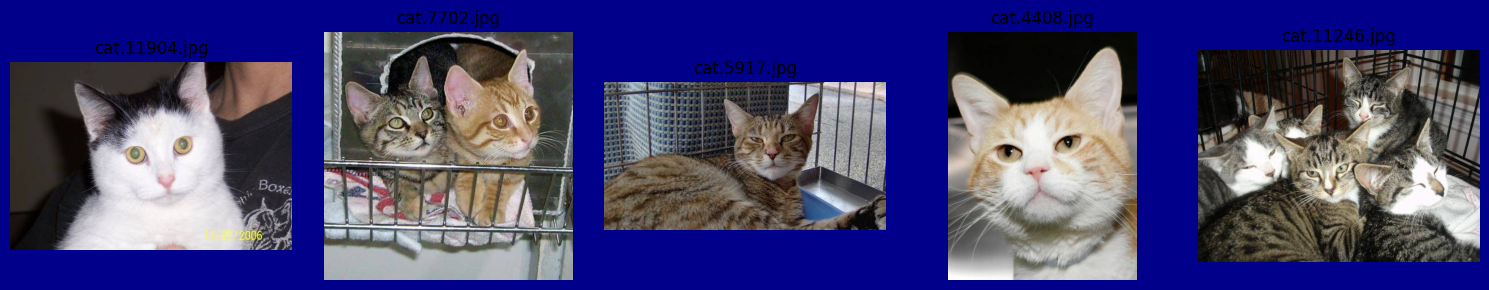

In [ ]:
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    image_filenames = os.listdir(path)

    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(image_filenames))

    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='darkblue')

    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Load the image using Matplotlib
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

# Specify the path containing the images to visualize
path_to_visualize = "/content/All_data/dogs_vs_cats/train/cats"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

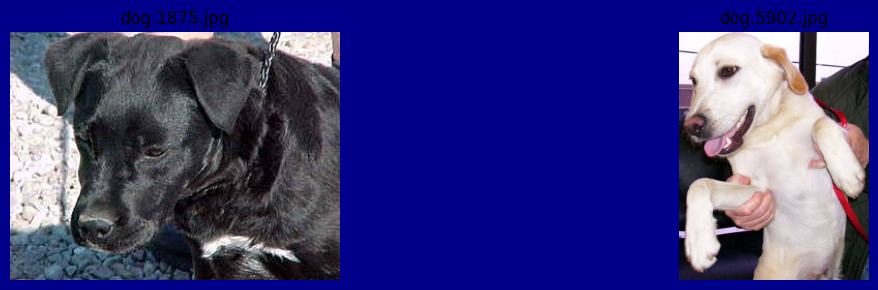

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/All_data/dogs_vs_cats/train/dogs"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=2)

In [ ]:
#Data_Dir
data_dir = '/content/All_data/dogs_vs_cats/train'

# Defining data generator with Data Augmentation
data_gen_augmented = ImageDataGenerator(rescale = 1/255.,
                                        validation_split = 0.2,
                                        zoom_range = 0.2,
                                        horizontal_flip= True,
                                        rotation_range = 20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2)
print('Augmented training Images:')
train_ds = data_gen_augmented.flow_from_directory(data_dir,
                                                              target_size = (224, 224),
                                                              batch_size = 32,
                                                              subset = 'training',
                                                              class_mode = 'binary')

#Testing Augmented Data
# Defining Validation_generator withour Data Augmentation
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

print('Unchanged Validation Images:')
validation_ds = data_gen.flow_from_directory(data_dir,
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Augmented training Images:
Found 16000 images belonging to 2 classes.
Unchanged Validation Images:
Found 4000 images belonging to 2 classes.


In [ ]:
# Load the pre-trained Xception model without the top (classification) layer
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
xception_base.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import Xception

# Load pretrained Xception base without top layers
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers initially (optional)
xception_base.trainable = False

model = Sequential()

model.add(xception_base)
model.add(AveragePooling2D(pool_size=(3, 3)))
model.add(Flatten())

# Added dense layers with BatchNormalization and Dropout for better training
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))  # Binary classification output

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 2, 2, 2048)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,224,233 (96.22 MB)

 Trainable params: 4,360,961 (16.64 MB)

 Non-trainable params: 20,863,272 (79.59 MB)

In [ ]:
model.compile(loss = BinaryCrossentropy(), optimizer = keras.optimizers.RMSprop(learning_rate = 0.0001, rho=0.9),
              metrics = ["accuracy"])

In [ ]:
early_stopping = EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True )

In [ ]:
history = model.fit(train_ds, epochs=5,
                    steps_per_epoch = len(train_ds),
                    validation_data = validation_ds,
                    validation_steps = len(validation_ds),
                    callbacks = early_stopping)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 242s 450ms/step - accuracy: 0.9324 - loss: 0.1709 - val_accuracy: 0.9833 - val_loss: 0.0455
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 246s 441ms/step - accuracy: 0.9731 - loss: 0.0781 - val_accuracy: 0.9870 - val_loss: 0.0421
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 221s 441ms/step - accuracy: 0.9773 - loss: 0.0642 - val_accuracy: 0.9875 - val_loss: 0.0387
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 261s 441ms/step - accuracy: 0.9762 - loss: 0.0681 - val_accuracy: 0.9858 - val_loss: 0.0409
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 261s 439ms/step - accuracy: 0.9791 - loss: 0.0627 - val_accuracy: 0.9877 - val_loss: 0.0361


In [ ]:
from tensorflow.keras.models import load_model
model.save("cat_vs_dog_model.h5")  # Saves as a directory
loaded_model = load_model("cat_vs_dog_model.h5")

# Make prediction
pred = loaded_model.predict(validation_ds)




125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step


In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

test_dir = "/content/All_data/test/dogs"
test_images = os.listdir(test_dir)

# Example: use the first 10 images
sample_test_images = test_images[:100]

images = []
image_names = []

for img_name in sample_test_images:
    img_path = os.path.join(test_dir, img_name)
    img = load_img(img_path, target_size=(224, 224))  # Resize to model input size (224x224)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    images.append(img_array)
    image_names.append(img_name)

X_test = np.array(images)

In [ ]:
predictions = model_1.predict(X_test)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/cat_vs_dog_model.h5')


In [ ]:
# Upload image

In [ ]:
path_img = "/content/cat.jpeg"

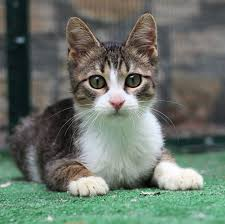

In [ ]:
from PIL import Image
img = Image.open(path_img)
img

In [ ]:
img = img.resize((224,224))

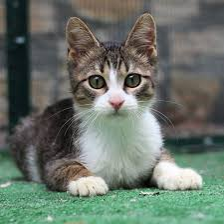

In [ ]:
img

In [ ]:
from PIL import Image
import numpy as np
import tensorflow as tf

# Step 1: Open the image and resize it to the size expected by the model (e.g., 224x224)
img = Image.open(path_img)
img_resized = img.resize((224, 224))  # Resize to 224x224 (adjust to your model's input size)

# Step 2: Convert the image to a numpy array and normalize it (if needed)
img_array = np.array(img_resized) / 255.0


img_array = np.expand_dims(img_array, axis=0)


prediction = model.predict(img_array)


predicted_class = 'dog' if prediction > 0.5 else 'cat'

print(f'Predicted class: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted class: cat
